# Spearman

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from igraph import Graph

In [37]:
def filter_cases(list_cases_name, min_cases):
    df = pd.read_csv(
        list_cases_name,
        encoding='utf-8',
        sep=',',
        usecols=['ibgeID', 'newCases', 'totalCases', 'date'],
        dtype={'ibgeID': int}
    )
    filtered_df = df[(df['totalCases'] >= min_cases) & (df['newCases'] >= 1) & (df['ibgeID'] > 1000)]
    filtered_df = filtered_df.drop_duplicates(subset='ibgeID')
    return filtered_df

def calculate_sequence(df, metric):
    sorted_df = df.sort_values(metric).reset_index()
    return sorted_df['geocode'].astype(str).tolist()


In [25]:
graph = Graph.Read_GraphML("/content/drive/MyDrive/Colab Notebooks/IC/Datas/networks/grafo_Peso_Geral.GraphML")
geocodes = list(map(int, graph.vs["geocode"]))
degrees = graph.degree()
clustering = graph.transitivity_local_undirected()
strength = graph.strength(weights="weight")
graph.es['w_inv'] = 1.0 / np.array(graph.es['weight'])
weighted_betweenness = graph.betweenness(vertices=None, directed=False, cutoff=None, weights='w_inv')
weighted_closeness = graph.closeness(vertices=None, mode='all', cutoff=None, weights='w_inv', normalized=True)
weighted_eignv = graph.evcent(directed=False, scale=True, weights='w_inv', return_eigenvalue=False)

metrics_df = pd.DataFrame({
    "geocode": geocodes,
    "degree": degrees,
    "clustering": clustering,
    "strength": strength,
    "Weighted_betweenness": weighted_betweenness,
    "Weighted_closeness": weighted_closeness,
    "Weighted_eignv": weighted_eignv
})

<ipython-input-25-fc340ed3bab0>:1: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:488
  graph = Graph.Read_GraphML("/content/drive/MyDrive/Colab Notebooks/IC/Datas/networks/grafo_Peso_Geral.GraphML")


In [8]:
metrics_df

,geocode,degree,clustering,strength,Weighted_betweenness,Weighted_closeness,Weighted_eignv
0,1302603,73,0.088661,4404.5,262625.0,26.176193,0.008371
1,1304260,5,1.000000,90.5,0.0,15.141611,0.000094
2,1302108,3,1.000000,77.0,0.0,14.840713,0.000115
3,5103809,12,0.818182,1566.0,10474.0,35.938431,0.001339
4,5108402,106,0.295597,5770.0,35617.0,37.027813,0.091256
...,...,...,...,...,...,...,...
5380,2111722,1,NaN,7.0,0.0,5.552964,0.002172
5381,2205359,1,NaN,7.0,0.0,5.857899,0.000254
5382,5104526,1,NaN,14.0,0.0,10.166832,0.000849
5383,5106240,1,NaN,21.0,0.0,13.413105,0.000566


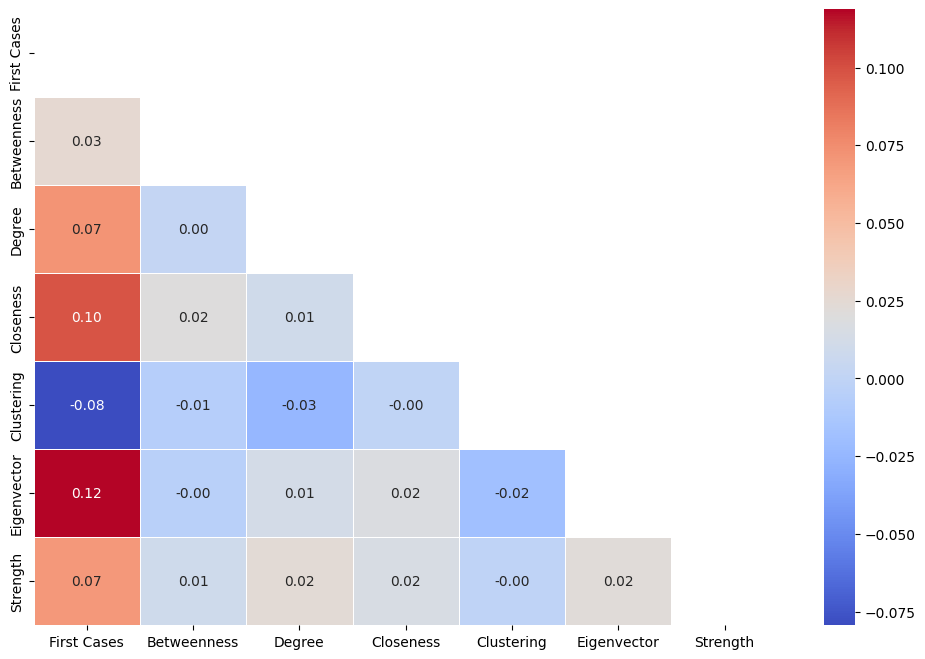

In [38]:
# filter_cases
min_cases = 5
list_cases_name = "/content/drive/MyDrive/Colab Notebooks/IC/Datas/Pre-processed/cases-brazil-cities-time_2020.csv"
df = filter_cases(list_cases_name, min_cases)

df = df.merge(metrics_df, left_on='ibgeID', right_on='geocode')
df = df.sort_values(by=['date', 'ibgeID']).reset_index()

# Inicializar df_seq
df_seq = pd.DataFrame()

# Calcular sequências para as métricas necessárias
df_seq['Degree Sequence'] = calculate_sequence(df, 'degree')
df_seq['Clustering Sequence'] = calculate_sequence(df, 'clustering')
df_seq['Strength Sequence'] = calculate_sequence(df, 'strength')
df_seq['Betweenness Sequence'] = calculate_sequence(df, 'Weighted_betweenness')
df_seq['Closeness Sequence'] = calculate_sequence(df, 'Weighted_closeness')
df_seq['Eigenvector Sequence'] = calculate_sequence(df, 'Weighted_eignv')
df_seq['Cases Sequence'] = calculate_sequence(df, 'ibgeID')

# Construir o DataFrame para correlação
df_corr = pd.DataFrame({
    'First Cases': df_seq['Cases Sequence'],
    'Betweenness': df_seq['Betweenness Sequence'],
    'Degree': df_seq['Degree Sequence'],
    'Closeness': df_seq['Closeness Sequence'],
    'Clustering': df_seq['Clustering Sequence'],
    'Eigenvector': df_seq['Eigenvector Sequence'],
    'Strength': df_seq['Strength Sequence'],
})

# Calcular a matriz de correlação usando o coeficiente de Spearman
corr = df_corr.corr(method='spearman')

# Criar a máscara para a parte superior da matriz de correlação
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plotar o heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)
plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/IC/Correlation_Spearman.pdf', bbox_inches='tight')
plt.show()

In [39]:
df

,index,date,ibgeID,newCases,totalCases,geocode,degree,clustering,strength,Weighted_betweenness,Weighted_closeness,Weighted_eignv
0,0,2020-03-05,3550308,3,6,3550308,1461,0.024956,76190.875,2037696.0,39.141769,1.000000
1,2,2020-03-12,3304557,11,13,3304557,461,0.072008,25986.000,606835.0,37.052771,0.405462
2,1,2020-03-12,4106902,5,5,4106902,427,0.092940,25745.250,1576371.0,39.702941,0.359608
3,4,2020-03-14,2611606,4,6,2611606,283,0.136782,16447.500,541835.0,37.679707,0.372832
4,3,2020-03-14,5300108,6,8,5300108,572,0.075925,35683.750,1113578.0,39.439342,0.568661
...,...,...,...,...,...,...,...,...,...,...,...,...
5376,5376,2020-12-20,3140605,2,6,3140605,7,0.857143,405.000,0.0,27.385701,0.003439
5377,5377,2020-12-20,3160801,1,5,3160801,5,0.700000,241.000,0.0,24.783110,0.000041
5378,5378,2020-12-26,3125507,1,5,3125507,17,0.838235,2739.000,30237.0,35.380479,0.001495
5379,5379,2020-12-29,2210391,4,8,2210391,1,NaN,14.000,0.0,9.809114,0.000619
